In [105]:
import numpy as np
import matplotlib.pyplot as plt
from util.vector_util import *
from util.color_util import *
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('retina')


class Sphere:
    def __init__(self, center, radius, color, specular):
        self.center = center
        self.radius = radius
        self.color = color
        self.specular = specular

class Lighting:
    def __init__(self, type, intensity, direction=None):
        self.type = type
        self.intensity = intensity
        self.direction = direction

        
viewport_size = 1
d = 1
Cw = 600
Ch = 600
Vw = 1
Vh = 1
inf = 10**9
O = (0, 0, 0)
BACKGROUND_COLOR = (255, 255, 255)

In [106]:
def CanvasToViewport(x, y):
    return (x*Vw/Cw, y*Vh/Ch, d)

In [107]:
def IntersectRaySphere(O, D, sphere): 
    r = sphere.radius
    CO = [O[0] - sphere.center[0], O[1] - sphere.center[1], O[2] - sphere.center[2]]
    a = dot(D, D)
    b = 2 * dot(CO, D)
    c = dot(CO, CO) - r*r
    discriminant = b*b - 4*a*c
    if discriminant < 0:
        return None, None
    t1 = (-b + math.sqrt(discriminant)) / (2*a)
    t2 = (-b - math.sqrt(discriminant)) / (2*a)
    return t1, t2

In [108]:
def computeLighting(P, N, lightingObj, specular):
    I = 0.0
    for light in lightingObj:
        if light.type == 'ambient':
            I += light.intensity
        else:
            L = light.direction
            if light.type == 'point':
                L = minus(light.direction, P)
            dot_product_L = dot(N, L)
            if dot_product_L >= 0:
                I += light.intensity * dot_product_L/(magnitude(N) * magnitude(L))
            R = minus(multiplication(N, 2 * dot(N, L)), L)
            dot_product_R = dot(R, N)
            if dot_product_R > 0:
                I += light.intensity * ((dot_product_R/(magnitude(N) * magnitude(R)))**specular)   
    return I

In [109]:
def TraceRay(O, D, t_min, t_max, spheresObj, lightingObj):
    closest_t = 10**9
    closest_sphere = None
    for sphere in spheresObj:
        t1, t2 = IntersectRaySphere(O, D, sphere)
        if t1 != None and t1 >= t_min and t1 <=  t_max and t1 < closest_t:
            closest_t = t1
            closest_sphere = sphere
        
        if t2 != None and t2 >= t_min and t2 <=  t_max and t2 < closest_t :
            closest_t = t2
            closest_sphere = sphere

    if closest_sphere == None :
        return BACKGROUND_COLOR
    P = addition(O, multiplication(D, closest_t))
    N = minus(P, closest_sphere.center)
    N = unit_vector(N)
    I = computeLighting(P, N, lightingObj, closest_sphere.specular)
    return intensity_multiplier(closest_sphere.color, I)

In [110]:
def putPixel(x, y, color, matrix):
    Sx = Cw//2 + x
    Sy = Ch//2 - y
    if Sx >= Cw or Sy >= Ch:
        return
    matrix[Sy][Sx] = color #y is the rows and x is the columns

In [111]:
def switch_lighting(case):
    if case[0] == 'ambient':
        return Lighting(case[0], case[1])
    elif case[0] == 'point':
        return Lighting(case[0], case[1], case[2])
    elif case[0] == 'directional':
        return Lighting(case[0], case[1], case[2])

def render():
    spheres =  [[(0, -1, 3), 1, (255, 0, 0), 1000], 
                [(2, 0, 4), 1 ,(0, 0, 255), 1000], 
                [(-2, 0, 4), 1 , (0, 255, 0), 100],
                [(0, -5001, 0), 5000 , (255, 255, 0), 1000]]
    spheresObj = []
    matrix = [[BACKGROUND_COLOR for i in range(Cw)] for j in range(Ch)]
    for sphere in spheres:
        spheresObj.append(Sphere(sphere[0], sphere[1], sphere[2], sphere[3]))
    lightings =  [["ambient", 0.2],
                  ["point", 0.4, (2, 1, 0)],
                  ["point", 0.6, (1, 4, 4)]]
    lightingObjs = []
    for i in lightings:
        lightingObjs.append(switch_lighting(i))
        
    for x in range(-Cw//2, Cw//2):
        for y in range(-Ch//2, Ch//2):
            D = CanvasToViewport(x, y)
            color = TraceRay(O, D, 1, 10**9, spheresObj, lightingObjs)
            putPixel(x, y, color, matrix)
    return matrix

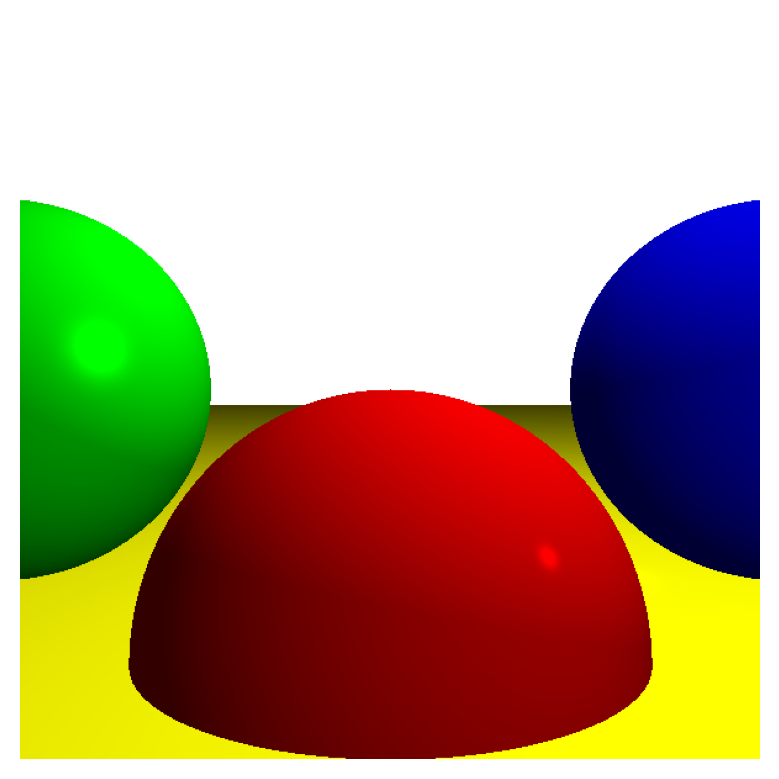

In [112]:
img = np.array(render())
plt.axis("off")
plt.imshow(img)